# Статистический анализ

Целью данного исследования является анализ данных о пользователях сервиса GoFast и их поездках с целью выявления закономерностей и проверки гипотез, которые могут помочь бизнесу сервиса вырасти. В исследовании используются данные о пользователях, их поездках и подписках, которые содержат следующую информацию:

**Датасет users_go:**

 - `user_id` уникальный идентификатор пользователя
 - `name` имя пользователя
 - `age` возраст
 - `city` город
 - `subscription_type` тип подписки (free, ultra)
 
**Датасет rides_go:**
 - `user_id` уникальный идентификатор пользователя
 - `distance` расстояние, которое пользователь проехал в текущей сессии (в метрах)
 - `duration` продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
 - `date` дата совершения поездки
 
**Датасет subscriptions_go:**
 - `subscription_type` тип подписки
 - `minute_price` стоимость одной минуты поездки по данной подписке
 - `start_ride_price` стоимость начала поездки
 - `subscription_fee` стоимость ежемесячного платежа


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## Шаг 1. Загрузка данных

### Загрузка датасетов в переменные

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

### Описание users_go

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
users['user_id'].max()

1534

Пропущенных значений нет. Необходимо проверить на наличие полных дубликатов, и на наличие неявных дубликатов в столбцах city и name.

Максимальное значение id - 1534, а данных в выгрузке 1564 - скорее всего в выгрузке присутствуют дубликаты, проверим на этапе предобработки.

### Описание rides_go

In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Пропусков нет. Необходимо:
- проверить наличие полных дубликатов;
- столбец date перевести к соответствующему типу данных;
- проверить на наличие выбросов и аномалий в столбцах distance и duration;

Судя по значениям данные в столбцах distance и duration это метры и минуты соответственно.

### Описание subscriptions_go

In [9]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions = subscriptions.rename(columns={'subscription_fee':'subscription_free'})
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_free  2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Таблица состоит из 2 строк, которые отображают тарифы для пользователей с подпиской и без.

## Шаг 2. Предобработка данных

### Изменение типов данных

Преобразуем столбец date в тип данных datetime

In [11]:
rides['date'] = pd.to_datetime(rides['date'])
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Добавление столбца

Проверим диапозон времени выгрузки:

In [12]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [13]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Данные представленны за один и тот же год. Месяцы не дублируются.

Добавим столбец с месяцами

In [14]:
rides['month'] = rides['date'].dt.month
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


### Работа с дубликатами

Пропущенных значений в датафреймах нет. Посмотрим на наличие дубликатов.

In [15]:
print(f'В датафрейме users {users.duplicated().sum()} дубликат')
print(f'в датафрейме rides {rides.duplicated().sum()} дубликатов')

В датафрейме users 31 дубликат
в датафрейме rides 0 дубликатов


Очистим датафрейм users от дубликатов

In [16]:
users = users.drop_duplicates()
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Проверим наличе неявных дубликатов в названиях городов и подписок.

In [17]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

С названиями городов всё в порядке. Видно, что большинство пользователей приложения из Пятигорска.

Проверим нет ли ошибки в названии подписок.

In [18]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

В названии подписок проблем нет.

## Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о поездках:

- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

### Частота встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


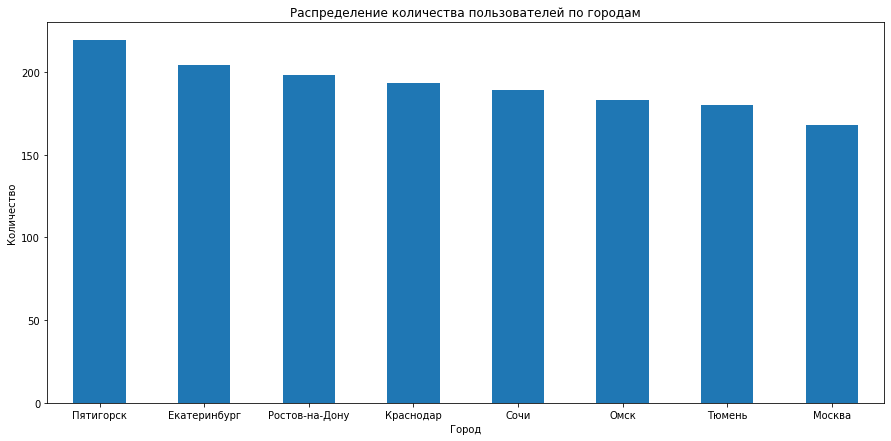

In [19]:
print(users['city'].value_counts())
users['city'].value_counts().plot(kind='bar', rot='0', figsize=(15, 7));
plt.title('Распределение количества пользователей по городам');
plt.xlabel('Город');
plt.ylabel('Количество');
plt.show();

Больше всего пользователей приложения встречается в Пятигорске (219). Меньше всего в Москве (168)

### Пользователи с подпиской и без

free     835
ultra    699
Name: subscription_type, dtype: int64


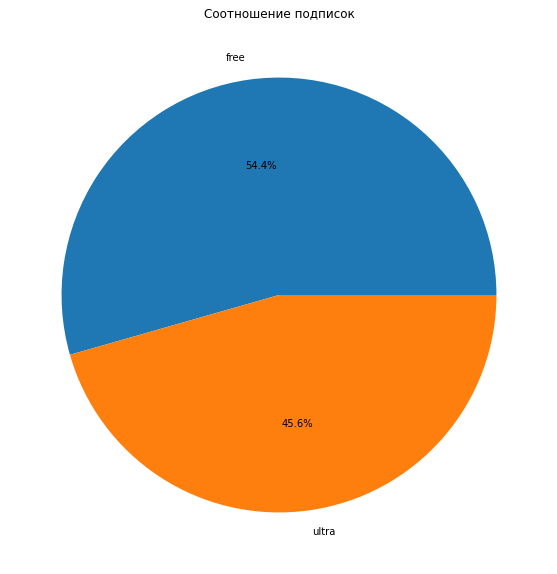

In [20]:
print(users['subscription_type'].value_counts())

fig = plt.figure(figsize=(10, 10))
plt.pie(users['subscription_type'].value_counts(), 
        labels=users['subscription_type'].value_counts().index, 
        autopct='%1.1f%%')
plt.title('Соотношение подписок')
plt.show()

Пользователей с подпиской 699(45,6%), пользователей без подписки 835(54,4%).

### Возраст пользователей

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64


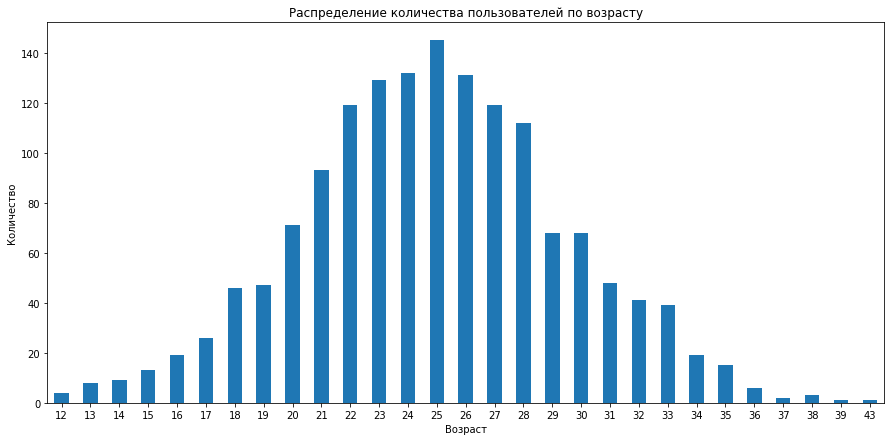

In [21]:
print(users['age'].value_counts())
users['age'].value_counts().sort_index().plot(kind='bar', rot='0', figsize=(15, 7));
plt.title('Распределение количества пользователей по возрасту');
plt.xlabel('Возраст');
plt.ylabel('Количество');
plt.show();

График значеий количества пользователей в зависимости от возраста похож на нормальное распределение с максимальным значением 25 лет(145 пользователей).

### Расстояние

In [22]:
print(rides['distance'].describe())

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


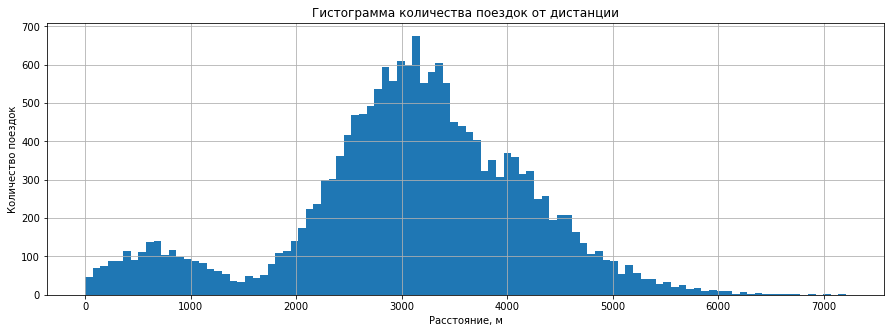

In [23]:
rides['distance'].hist(bins=100, figsize=(15, 5));
plt.title('Гистограмма количества поездок от дистанции');
plt.xlabel('Расстояние, м');
plt.ylabel('Количество поездок');
plt.show();

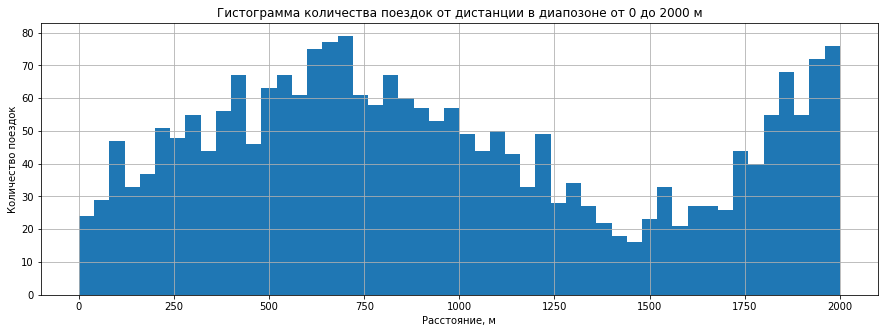

In [24]:
rides['distance'].hist(bins=50, figsize=(15, 5), range=(0, 2000));
plt.title('Гистограмма количества поездок от дистанции в диапозоне от 0 до 2000 м');
plt.xlabel('Расстояние, м');
plt.ylabel('Количество поездок');
plt.show();

In [25]:
rides.query('distance < 1000')['distance'].count() / rides['distance'].count()

0.07593535532433031

Наибольшая часть пользователей проезжают дистанцию около 3км. График похож на нормальное распределение, однако есть небольшой всплеск значений в диапозоне до 1км. Он составляет порядка 7,6% от общего числа поездок. 

### Продолжительность поездки

In [26]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

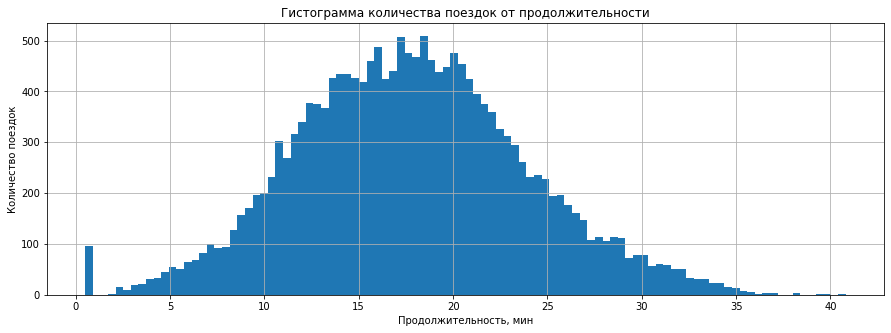

In [33]:
rides['duration'].hist(bins=100, figsize=(15, 5));
plt.title('Гистограмма количества поездок от продолжительности');
plt.xlabel('Продолжительность, мин');
plt.ylabel('Количество поездок');
plt.show();

График времени поездки похож на нормальное распределение с максимальными значениями в диапозоне 15-20 минут. Однако есть некое искажение около значения 0, рассмотрим по подробнее.

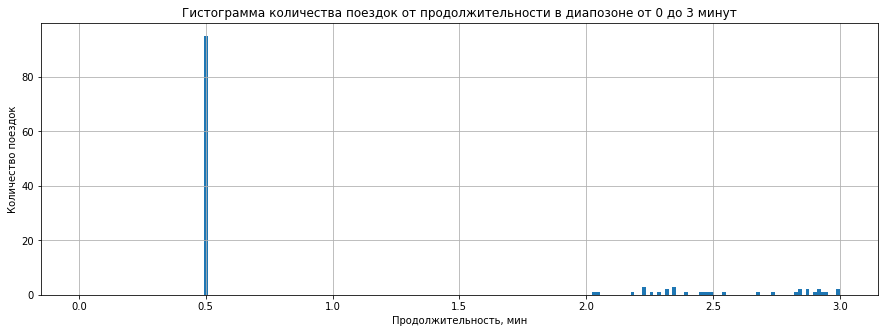

In [32]:
rides['duration'].hist(bins=200, figsize=(15, 5), range=(0, 3));
plt.title('Гистограмма количества поездок от продолжительности в диапозоне от 0 до 3 минут');
plt.xlabel('Продолжительность, мин');
plt.ylabel('Количество поездок');
plt.show();

In [29]:
rides.query('duration == 0.5').tail()

,user_id,distance,duration,date,month
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2
17909,1524,4103.998874,0.5,2021-06-18,6


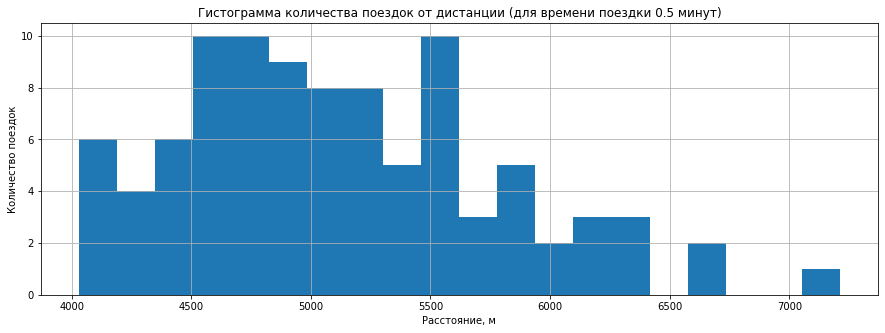

0.005257914545052026

In [34]:
rides.query('duration == 0.5')['distance'].hist(bins=20, figsize=(15, 5));
plt.title('Гистограмма количества поездок от дистанции (для времени поездки 0.5 минут)');
plt.xlabel('Расстояние, м');
plt.ylabel('Количество поездок');
plt.show();
rides.query('duration == 0.5')['duration'].count() / rides['duration'].count()

Выброс составляет менее одного процента.
Очевидно, что за пол минуты самокат не сможет преодолеть расстояние 4км и больше(для этого его скорость должна быть минимум 480км/ч, что невозможно).

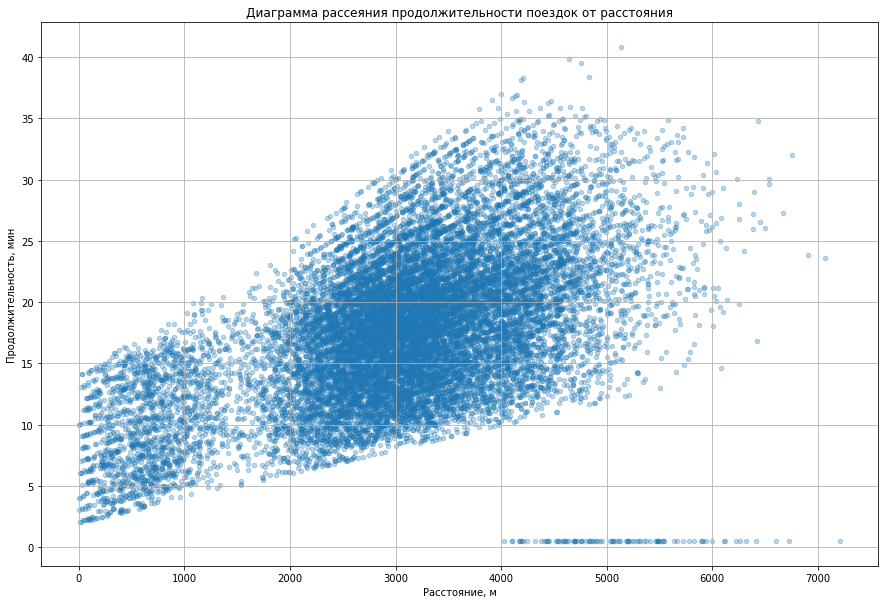

In [35]:
rides.plot.scatter(x='distance', y='duration', alpha=0.3, figsize=(15, 10), grid=True);
plt.title('Диаграмма рассеяния продолжительности поездок от расстояния');
plt.xlabel('Расстояние, м');
plt.ylabel('Продолжительность, мин');
plt.show();

Эти значения продолжительности поездки записаны некорректно. Стоит выяснить причину(возможно, эти записи отображены в часах, а не в минутах, для получаса подобное расстояние выглядит правдаподобнее). Однако не стоит исключать и технической ошибки, связанной с счетчиком времени.

## Шаг 4. Объединение данных

### Объединение таблиц

In [36]:
users_rides = pd.merge(users, rides, how='outer', on='user_id')
data = pd.merge(users_rides, subscriptions, how='outer', on='subscription_type')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_free
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_free  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


#### Пользователи без подписки

Создадим датафрейм data_free для пользователей без подписки.

In [38]:
data_free = data.query('subscription_type == "free"').reset_index(drop=True)
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_free
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


#### Пользователи с подпиской

И датафрейм data_ultra для пользователей с подпиской.

In [39]:
data_ultra = data.query('subscription_type == "ultra"').reset_index(drop=True)
data_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_free
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


### Графики для пользователей free и ultra

#### Пройденное расстояние

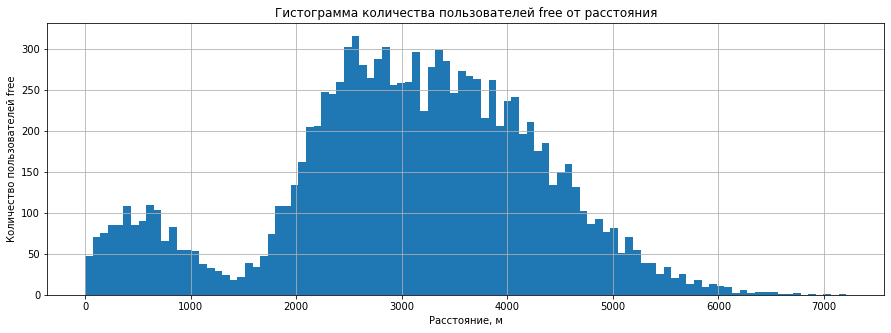

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [42]:
data_free['distance'].hist(bins=100, figsize=(15, 5));
plt.title('Гистограмма количества пользователей free от расстояния');
plt.xlabel('Расстояние, м');
plt.ylabel('Количество пользователей free');
plt.show();
data_free['distance'].describe()

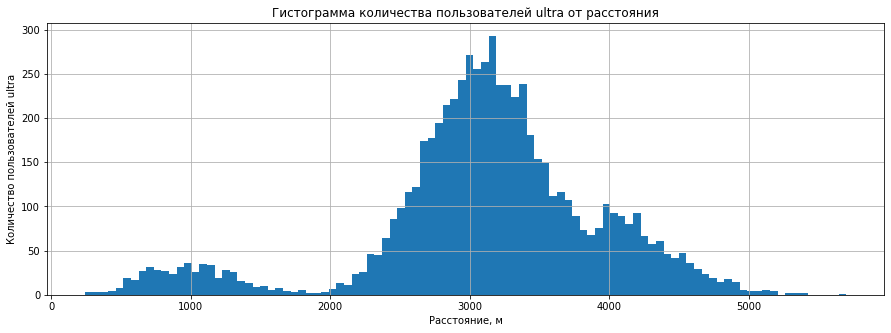

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [43]:
data_ultra['distance'].hist(bins=100, figsize=(15, 5));
plt.title('Гистограмма количества пользователей ultra от расстояния');
plt.xlabel('Расстояние, м');
plt.ylabel('Количество пользователей ultra');
plt.show();
data_ultra['distance'].describe()

Для пользователей без подписки распределение имеет более широкий "колокол" с диапозоном от 2500м до 4000м.

Для пользователей с подпиской ширина "колокола" уже с диапозоном от 2900м до 3500м.

#### Продолжительность поездки

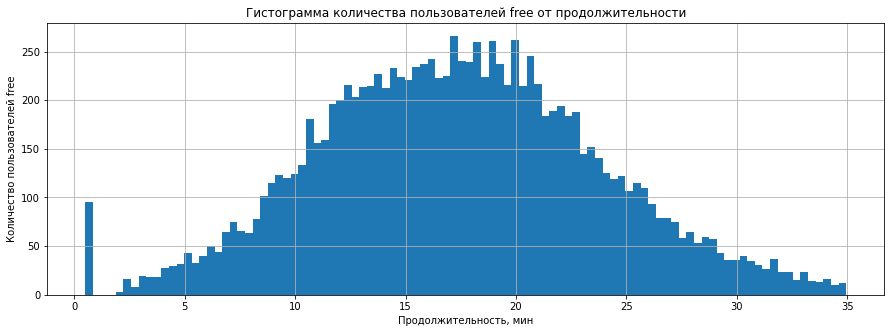

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [44]:
data_free['duration'].hist(bins=100, figsize=(15, 5));
plt.title('Гистограмма количества пользователей free от продолжительности');
plt.xlabel('Продолжительность, мин');
plt.ylabel('Количество пользователей free');
plt.show();
data_free['duration'].describe()

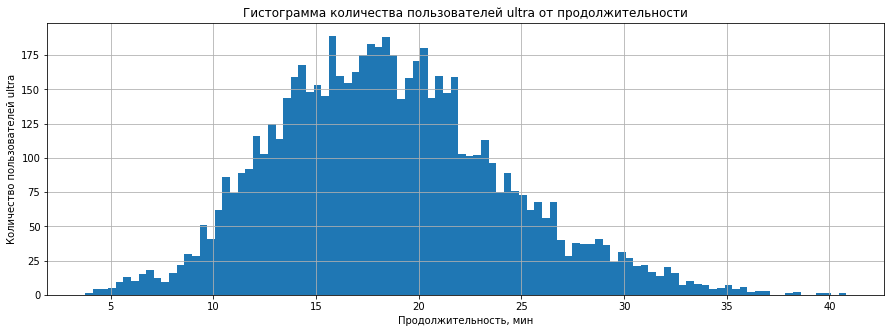

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [45]:
data_ultra['duration'].hist(bins=100, figsize=(15, 5));
plt.title('Гистограмма количества пользователей ultra от продолжительности');
plt.xlabel('Продолжительность, мин');
plt.ylabel('Количество пользователей ultra');
plt.show();
data_ultra['duration'].describe()

Графики распределены схожим образом с максимальной концентрацией значений в диапозоне от 15 до 20 минут.

Однако выброс в районе 0,5 минут отсутствует для пользователей с подпиской. 
Возможно, этот выброс может быть связан со стоимостью старта поездки, однако пройденое расстояние более 4км для этих записей выглядит подозрительно.

#### Распределение пройденого расстояния от времени

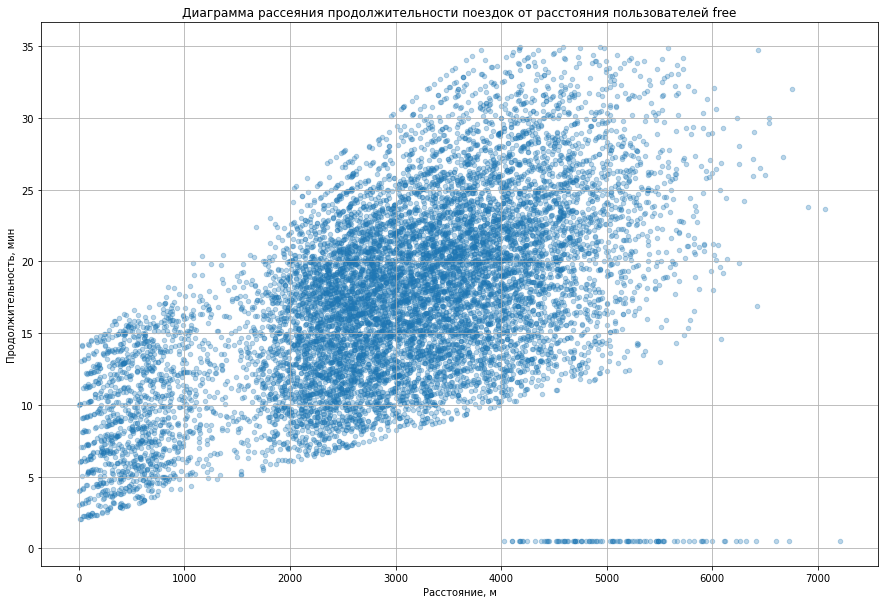

In [46]:
data_free.plot.scatter(x='distance', y='duration', alpha=0.3, figsize=(15, 10), grid=True);
plt.title('Диаграмма рассеяния продолжительности поездок от расстояния пользователей free');
plt.xlabel('Расстояние, м');
plt.ylabel('Продолжительность, мин');
plt.show();

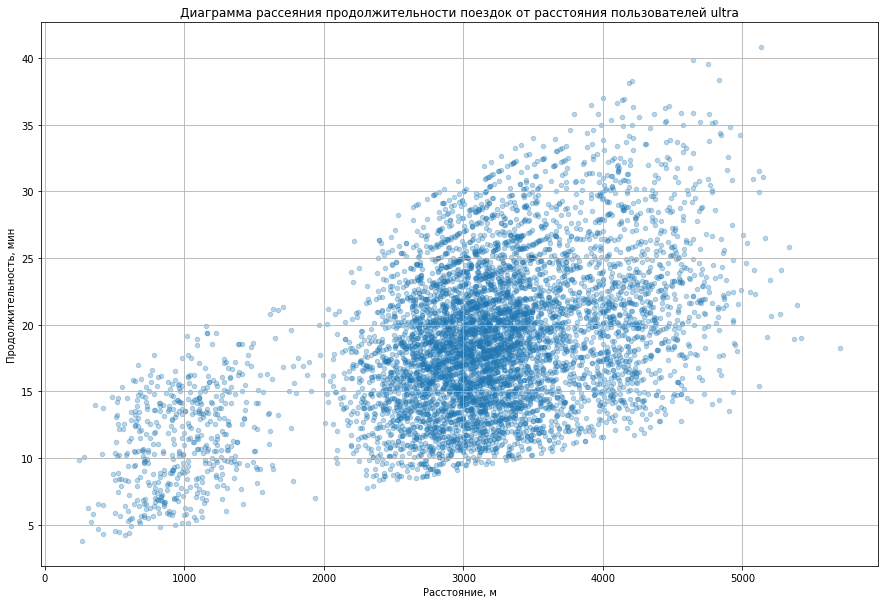

In [47]:
data_ultra.plot.scatter(x='distance', y='duration', alpha=0.3, figsize=(15, 10), grid=True);
plt.title('Диаграмма рассеяния продолжительности поездок от расстояния пользователей ultra');
plt.xlabel('Расстояние, м');
plt.ylabel('Продолжительность, мин');
plt.show();

Значения для пользователей с подпиской и без имеют схожие распределения. 

## Шаг 5. Подсчёт выручки

### Агрегированные данные

Для агрегирования данных сгруппируем таблицу для сумм значений длительности поездки, продолжительности поездки и количества поездок каждого пользователя по месяцам.

In [60]:
agg_data = data.groupby(['user_id', 'month']).agg({'distance': 'sum', 'duration': 'sum', 'date': 'count'}).reset_index()
agg_data = agg_data.rename(columns={'date':'count_per_month'})
agg_data

,user_id,month,distance,duration,count_per_month
0,1,1,7027.511294,41.416640,2
1,1,4,754.159807,6.232113,1
2,1,8,6723.470560,44.776802,2
3,1,10,5809.911100,31.578017,2
4,1,11,7003.499363,53.397424,3
...,...,...,...,...,...
11326,1534,6,3409.468534,24.812678,2
11327,1534,8,7622.453034,47.205960,2
11328,1534,9,4928.173852,22.560373,1
11329,1534,11,13350.015305,76.342174,4


Сводная таблица для пользователей с подпиской

In [61]:
pivot_ultra = data_ultra.pivot_table(index=['user_id', 'month'], 
                              values=['distance', 'duration', 'name'], 
                              aggfunc={'distance':'sum', 'duration':'sum', 'name':'count'})
pivot_ultra.columns = ['distance_per_month', 'duration_per_month', 'count_per_month']
pivot_ultra

distance_per_month  duration_per_month  count_per_month
user_id month                                                         
1       1             7027.511294           41.416640                2
        4              754.159807            6.232113                1
        8             6723.470560           44.776802                2
        10            5809.911100           31.578017                2
        11            7003.499363           53.397424                3
...                           ...                 ...              ...
699     6             4072.797406           16.575991                1
        8             7018.324143           44.281768                2
        9             6364.861911           30.282412                2
        10            4707.845501           15.839579                1
        12            3202.890770           25.217345                1

[4533 rows x 3 columns]

Сводная таблица для пользователей без подписки

In [62]:
pivot_free = data_free.pivot_table(index=['user_id', 'month'], 
                              values=['distance', 'duration', 'name'], 
                              aggfunc={'distance':'sum', 'duration':'sum', 'name':'count'})
pivot_free.columns = ['distance_per_month', 'duration_per_month', 'count_per_month']
pivot_free

distance_per_month  duration_per_month  count_per_month
user_id month                                                         
700     1             2515.690719           14.944286                1
        2            13446.659764           85.829845                5
        3             3798.334905           18.243756                1
        4             2984.551206           15.424899                1
        6             5927.650988           28.077657                2
...                           ...                 ...              ...
1534    6             3409.468534           24.812678                2
        8             7622.453034           47.205960                2
        9             4928.173852           22.560373                1
        11           13350.015305           76.342174                4
        12            2371.711192           15.893917                1

[6798 rows x 3 columns]

### Рассчет выручки

#### Выручка для всех пользователй 

Расчитаем выручку с поездок всех пользователей помесячно.

In [63]:
agg_data['duration'] = np.ceil(agg_data['duration'])

def monthly_revenue(row):
    if row['user_id'] in data_ultra['user_id'].values:
        return row['duration']*6 + 199
    elif row['user_id'] in data_free['user_id'].values:
        return row['duration']*8 + row['count_per_month']*50
 
agg_data['monthly_revenue'] = agg_data.apply(monthly_revenue, axis=1)
agg_data

,user_id,month,distance,duration,count_per_month,monthly_revenue
0,1,1,7027.511294,42.0,2,451.0
1,1,4,754.159807,7.0,1,241.0
2,1,8,6723.470560,45.0,2,469.0
3,1,10,5809.911100,32.0,2,391.0
4,1,11,7003.499363,54.0,3,523.0
...,...,...,...,...,...,...
11326,1534,6,3409.468534,25.0,2,300.0
11327,1534,8,7622.453034,48.0,2,484.0
11328,1534,9,4928.173852,23.0,1,234.0
11329,1534,11,13350.015305,77.0,4,816.0


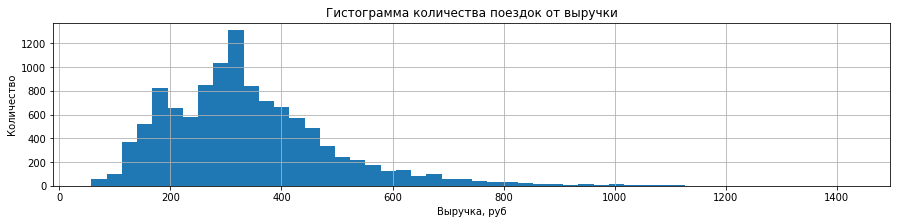

In [64]:
agg_data['monthly_revenue'].hist(bins=50, figsize=(15,3));
plt.title('Гистограмма количества поездок от выручки');
plt.xlabel('Выручка, руб');
plt.ylabel('Количество');
plt.show();

Пик находится в районе 300 рублей в месяц.

#### Выручка для пользователей ultra

Расчитаем выручку с поездок всех пользователей помесячно для пользователей c подпиской.

In [65]:
pivot_ultra['duration_per_month'] = np.ceil(pivot_ultra['duration_per_month'])
pivot_ultra['revenue'] = 6 * pivot_ultra['duration_per_month'] + 199
pivot_ultra.head()

distance_per_month  duration_per_month  count_per_month  \
user_id month                                                            
1       1             7027.511294                42.0                2   
        4              754.159807                 7.0                1   
        8             6723.470560                45.0                2   
        10            5809.911100                32.0                2   
        11            7003.499363                54.0                3   

               revenue  
user_id month           
1       1        451.0  
        4        241.0  
        8        469.0  
        10       391.0  
        11       523.0

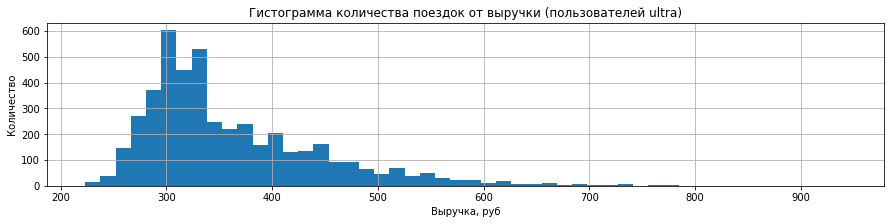

In [77]:
pivot_ultra['revenue'].hist(bins=50, figsize=(15, 3));
plt.title('Гистограмма количества поездок от выручки (пользователей ultra)');
plt.xlabel('Выручка, руб');
plt.ylabel('Количество');
plt.show();

Пик приходится на значения в районе 300 рублей в месяц.

#### Выручка для пользователей free

Расчитаем выручку с поездок всех пользователей помесячно для пользователей без подписки.

In [68]:
pivot_free['duration_per_month'] = np.ceil(pivot_free['duration_per_month'])
pivot_free['revenue'] = 50 * pivot_free['count_per_month'] + 8 * pivot_free['duration_per_month']
pivot_free.head()

distance_per_month  duration_per_month  count_per_month  \
user_id month                                                            
700     1             2515.690719                15.0                1   
        2            13446.659764                86.0                5   
        3             3798.334905                19.0                1   
        4             2984.551206                16.0                1   
        6             5927.650988                29.0                2   

               revenue  
user_id month           
700     1        170.0  
        2        938.0  
        3        202.0  
        4        178.0  
        6        332.0

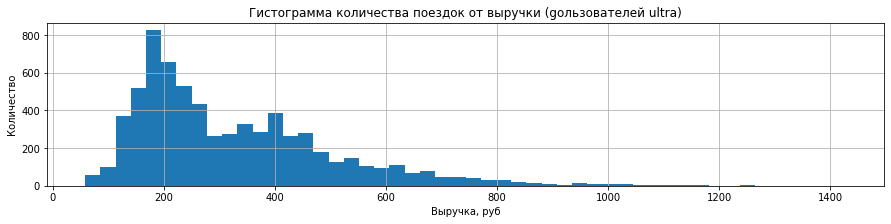

In [69]:
pivot_free['revenue'].hist(bins=50, figsize=(15, 3));
plt.title('Гистограмма количества поездок от выручки (gользователей ultra)');
plt.xlabel('Выручка, руб');
plt.ylabel('Количество');
plt.show();

Пик приходится на значения в районе 200 рублей в месяц.

## Шаг 6. Проверка гипотез

### Время поездок пользователей с подпиской и без

Нулевая гипотеза будет звучать так:
- средняя продолжительность поездки у пользователей с подпиской и без равны;

Тогда альтернативная гипотеза:
- средняя продолжительность поездки у пользователей с подпиской больше, чем у пользователей без подписки;

Мы имеем дело с двумя группами, которые не зависят друг от друга и хотим определить значимо ли различие между средними значениями продолжительности поездок в этих двух группах. Будем использовать тест Стьюдента

In [70]:
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False, alternative='greater')

print('значение p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Нулевую гипотезу стоит отвергнуть в пользу альтернативной гипотезы')
else:
    print('Не отвергаем нулевую гипотезу.')
        

значение p-value: 5.6757813771289775e-37
Нулевую гипотезу стоит отвергнуть в пользу альтернативной гипотезы


Уровень значимости (p-value) очень маленький (меньше 0.05), что говорит о том, что мы можем отвергнуть нулевую гипотезу и принять альтернативную гипотезу о том, что средняя продолжительность поездок у пользователей с подпиской больше, чем у пользователей без подписки. Это может означать, что пользователи с подпиской проводят более продолжительные поездки, что может быть выгодно для компании.

### Расстояние одной поездки 3130 метров

Для проведения теста сформулируем нулевую гипотезу:

- среднее расстояние поездки пользователей с подпиской равно 3130 метров;

Альтернативная гипотеза:

- среднее расстояние поездки пользователей с подпиской меньше, чем 3130 метров;

In [71]:
alpha = 0.05
distance = 3130

results = st.ttest_1samp(data_ultra['distance'], popmean=distance, alternative='less')

print('Значение p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Нулевую гипотезу стоит отвергнуть в пользу альтернативной гипотезы')
    print('Среднее расстояние поездки пользователей с подпиской меньше 3130 метров.')
else:
    print('Не отвергаем нулевую гипотезу')

Значение p-value: 0.08046311521502146
Не отвергаем нулевую гипотезу


На уровне значимости 0.05 мы не можем отвергнуть нулевую гипотезу, что среднее расстояние поездки пользователей с подпиской не меньше, чем 3130 метров.

В целом, полученные результаты говорят о том, что нет достаточно убедительных доказательств в пользу того, что среднее расстояние поездки пользователей с подпиской меньше, чем 3130 метров.

### Помесячная выручка

Для проведения теста сформулируем нулевую гипотезу:

- помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки;

Альтернативная гипотеза:

- помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки;

In [72]:
alpha = 0.05

results = st.ttest_ind(pivot_ultra['revenue'], pivot_free['revenue'], equal_var=False, alternative='greater')

print('Значение p-value:', results.pvalue)

if results.pvalue < alpha:
    print('нулевую гипотезу стоит отвергнуть в пользу альтернативной гипотезы')
else:
    print('Не отвергаем нулевую гипотезу')

Значение p-value: 1.0718729651261336e-44
нулевую гипотезу стоит отвергнуть в пользу альтернативной гипотезы


Помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки.

### Обращения в техническую поддержку

Для проверки гипотезы о снижении количества обращений в техподдержку после обновления серверов можно использовать парный t-тест.

Нулевая гипотеза будет звучать так: 

- количество обращений до и после обновления серверов не отличается; 

Альтернативная гипотеза: 

- количество обращений после обновления серверов значимо снизилось;

Далее используется метод st.ttest_rel()

In [73]:
try:
    alpha = 0.05
    
    df['before'] # данные об обращениях до обновления серверов
    df['after']  # данные об обращениях после обновления серверов
    
    test_results = st.ttest_rel(df['before'], df['after'], alternative='less')
    
    if test_results.pvalue < alpha:
        print('Стоит отвергнуть гипотезу в пользу альтернативной гипотезы')
    else:
        print('Не отвергаем нулевую гипотезу')
        
except:
    
    print('датафрейм df не объявлен - это пример')

датафрейм df не объявлен - это пример


Если полученное значение p-value оказалось меньше выбранного уровня значимости, то можно сделать вывод о том, что обновление серверов привело к снижению количества обращений в техподдержку. В противном случае, нулевая гипотеза не может быть отвергнута, и значит, нет оснований утверждать, что обновление серверов привело к значимому снижению количества обращений.

## Шаг 7. Дополнительные распределения

### Промокоды

Для решения задачи мы можем использовать биномиальное распределение, которое описывает вероятность наступления события в серии из n независимых испытаний, каждое из которых имеет одинаковую вероятность успеха p.

Для данной задачи:

n - количество промокодов, разосланных существующим клиентам
p - вероятность того, что клиент продлит подписку после использования бесплатного месяца

Таким образом, вероятность того, что как минимум 100 клиентов продлят подписку при использовании n промокодов, может быть выражена следующим образом:

P(X ≥ 100) = 1 - P(X < 100)

где X - случайная величина, описывающая количество клиентов, которые продлят подписку после использования промокода.

Мы хотим, чтобы вероятность не выполнить план была примерно 5%, т.е.

P(X < 100) ≈ 0.05

Для определения значения n, при котором P(X < 100) ≈ 0.05, мы можем использовать функцию биномиального распределения.

Необходимое число промокодов: 1161


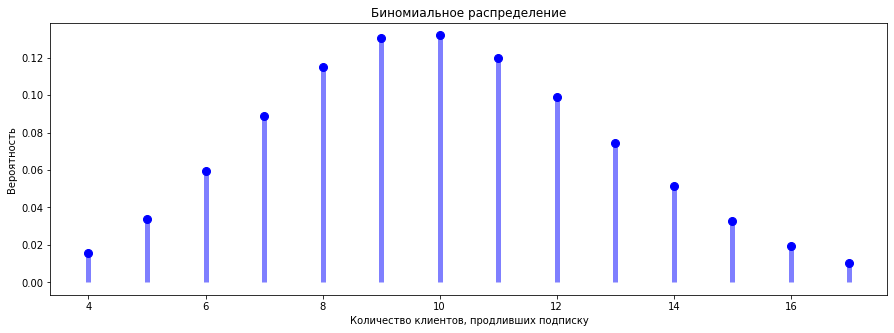

In [78]:
p = 0.1
alpha = 0.05
k = 100
n = 0

while st.binom.cdf(k - 1, n, p) > alpha:
    n +=1
    
    
print('Необходимое число промокодов:', n)

x = np.arange(st.binom.ppf(0.01, k, p), st.binom.ppf(0.99, k, p))
plt.figure(figsize=(15, 5))
plt.plot(x, st.binom.pmf(x, k, p), 'bo', ms=8, label='binom pmf')
plt.vlines(x, 0, st.binom.pmf(x, k, p), colors='b', lw=5, alpha=0.5)
plt.title("Биномиальное распределение")
plt.xlabel("Количество клиентов, продливших подписку")
plt.ylabel("Вероятность")
plt.show()